In [60]:
import pandas as pandas
import datetime
import pandas as pd
from datetime import date, timedelta
import matplotlib.pyplot as plt 
plt.style.use('fivethirtyeight')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA 
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm 
import warnings

In [61]:
data = pd.read_excel('data skripsi.xlsx')
print(data.head())

  Kabupaten  Tahun  Produksi  Luas Panen  Curah Hujan  Kelembapan  \
0     Toili   2004   1449671      359817         2400        84.0   
1     Toili   2005   1429440      336765         2410        83.9   
2     Toili   2006   1550548      295212         2420        83.8   
3     Toili   2007   1718193      315131         2430        83.7   
4     Toili   2008   1522556      367636         2440        83.6   

   Suhu rata-rata  
0           26.40  
1           26.41  
2           26.42  
3           26.43  
4           26.44  


In [62]:
import plotly.express as px
figure = px.line(data, x="Tahun", y="Produksi", title="Hasil Prediksi Padi")
figure.show()

<Figure size 640x480 with 0 Axes>

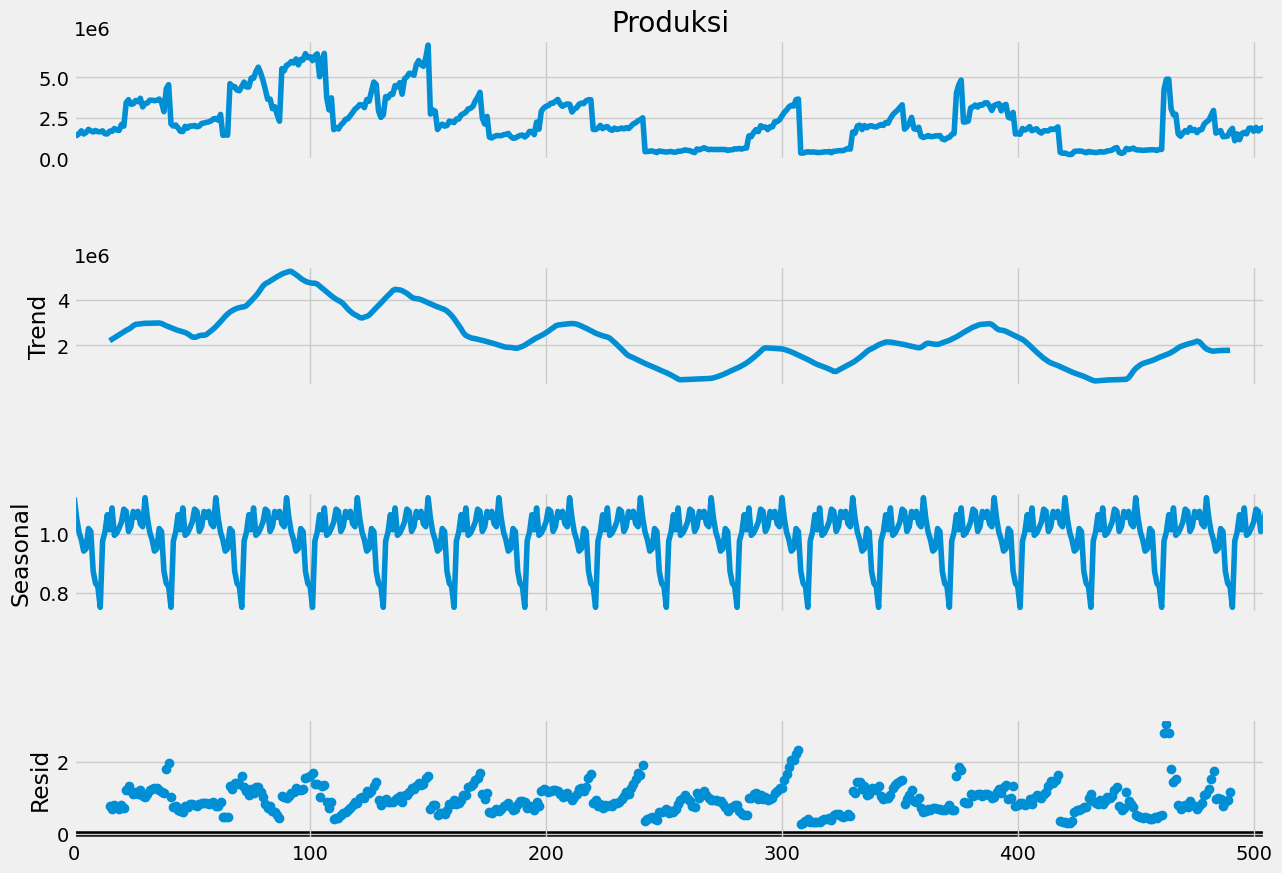

In [63]:
result = seasonal_decompose(data["Produksi"], model='multiplicative', period=30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(15,10)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

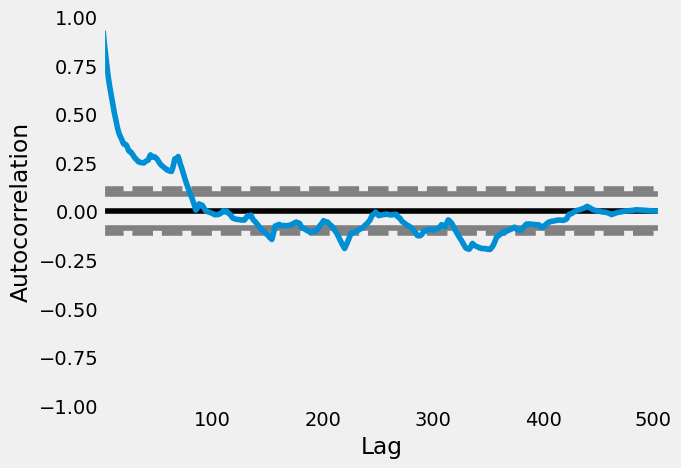

In [64]:
pd.plotting.autocorrelation_plot(data["Produksi"])

In [65]:
d = 1 
p = 3 

In [66]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(data["Produksi"])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

if adf_result[1] < 0.05:
    print("Data stasioner (tolak H0)")
else:
    print("Data tidak stasioner (gagal tolak H0)")


ADF Statistic: -4.323481255701208
p-value: 0.0004044105498573557
Data stasioner (tolak H0)


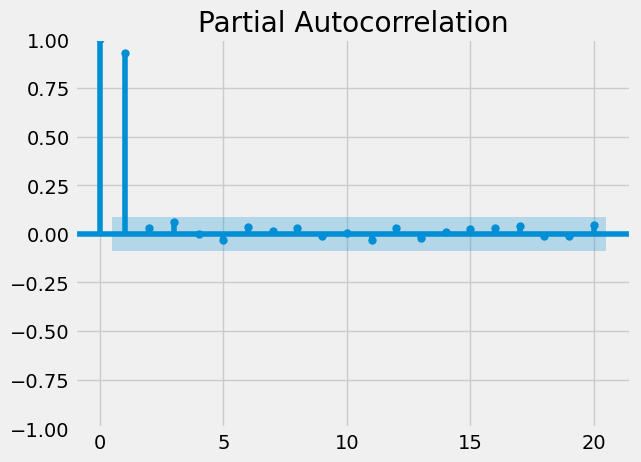

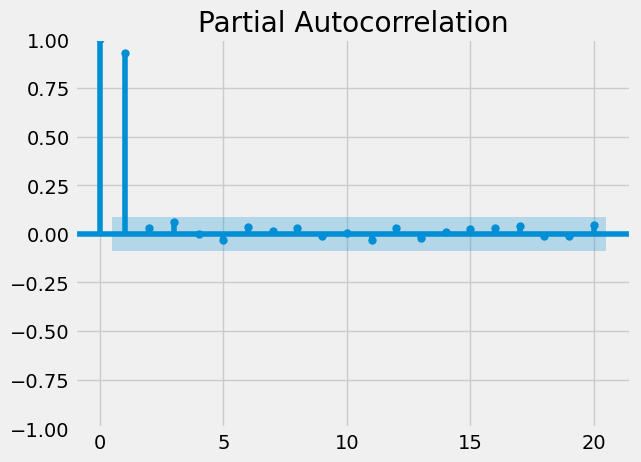

In [67]:
# mencari nilai q
plot_pacf(data["Produksi"], lags = 20)

In [68]:
q= 2

In [69]:

# Membuat model ARIMA (bukan SARIMA karena data tahunan)
model = sm.tsa.ARIMA(data["Produksi"], order=(p,d,q))
model = model.fit()

print(model.summary())

c:\Users\asus\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\asus\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                               SARIMAX Results                                
Dep. Variable:               Produksi   No. Observations:                  506
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -7390.044
Date:                Mon, 21 Jul 2025   AIC                          14792.087
Time:                        12:16:21   BIC                          14817.434
Sample:                             0   HQIC                         14802.029
                                - 506                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1053      0.053     -1.971      0.049      -0.210      -0.001
ar.L2          0.9034      0.026     34.119      0.000       0.852       0.955
ar.L3          0.0141      0.051      0.276      0.7

In [70]:
# membuat prediksi
predictions = model.predict(len(data), len(data)+5)
print(predictions)

506    1.931853e+06
507    1.899622e+06
508    1.886170e+06
509    1.858196e+06
510    1.848533e+06
511    1.824088e+06
Name: predicted_mean, dtype: float64


<Axes: >

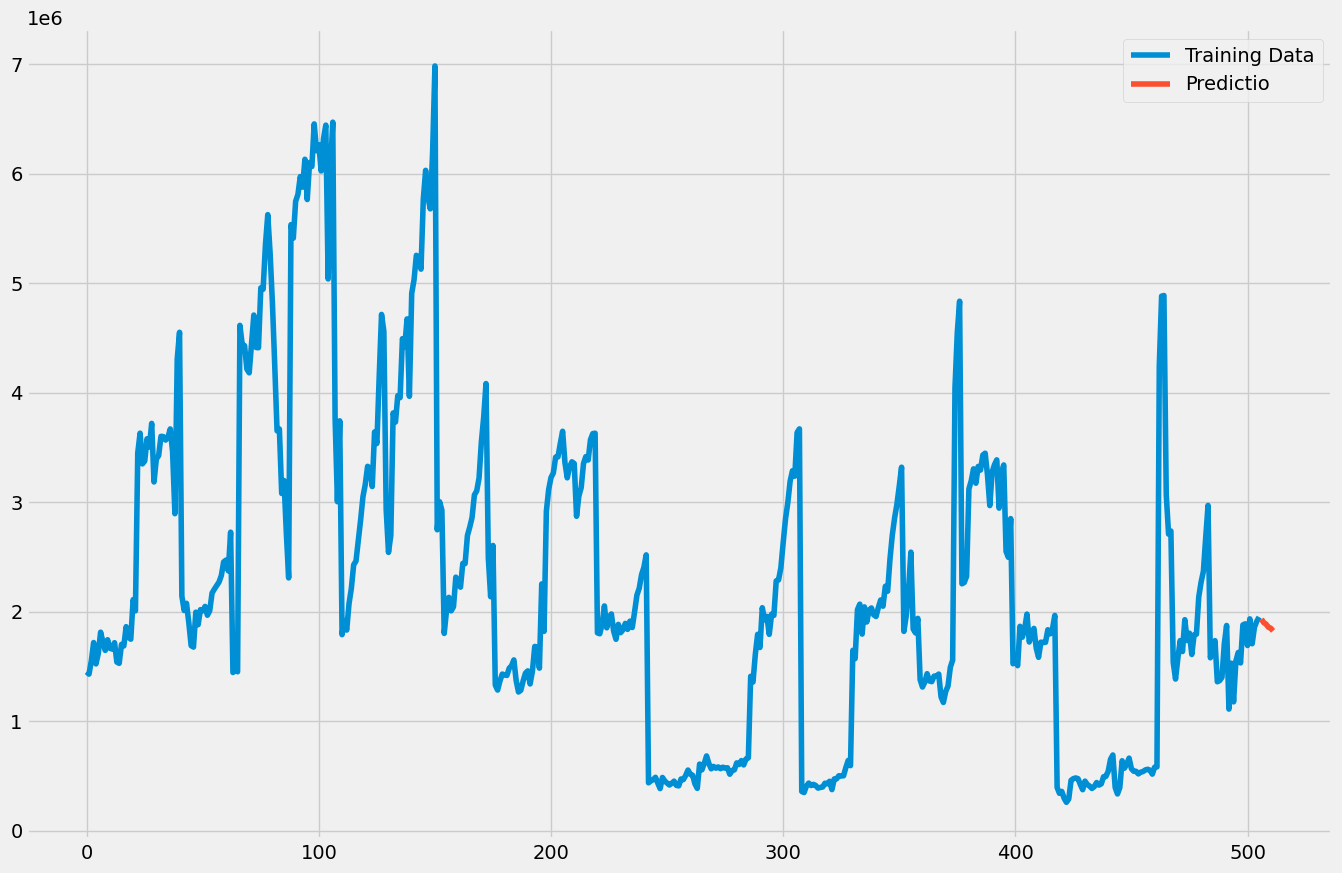

In [71]:
#buat grafik
data["Produksi"].plot(legend=True,
                      label="Training Data",
                      figsize=(15,10))
predictions.plot(legend=True,label="Predictio")

In [72]:
# Tambahkan index tahun jika diperlukan
last_year = data["Tahun"].iloc[-1]
future_years = pd.date_range(start=f"{last_year+1}-12-31", periods=6, freq='Y')
predictions.index = future_years

C:\Users\asus\AppData\Local\Temp\ipykernel_9680\4265232154.py:3: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



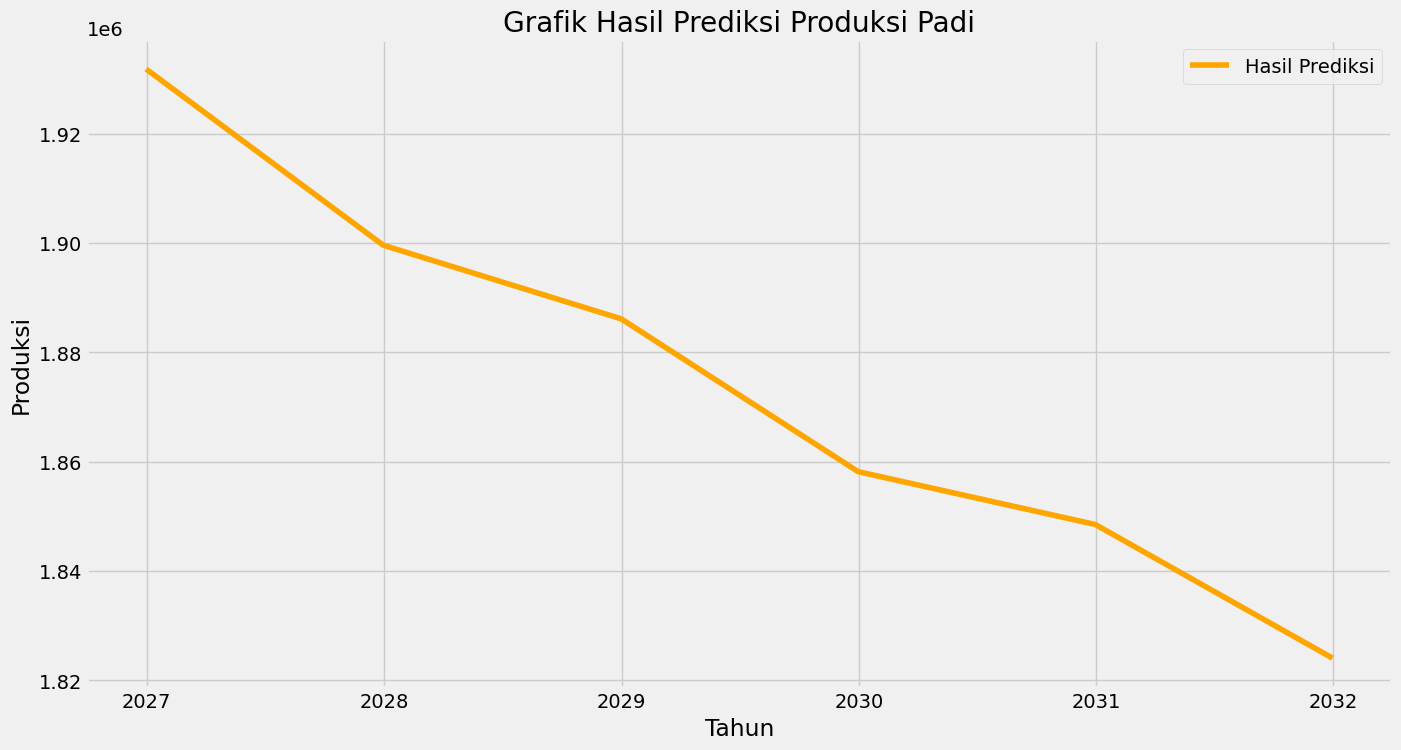

In [73]:
# Tampilkan hanya grafik hasil prediksi
plt.figure(figsize=(15, 8))
plt.plot(predictions, label="Hasil Prediksi", color='orange')
plt.title("Grafik Hasil Prediksi Produksi Padi")
plt.xlabel("Tahun")
plt.ylabel("Produksi")
plt.legend()
plt.show()


In [74]:
# Misal kita uji 5 tahun terakhir sebagai test set
train = data["Produksi"][:-5]
test = data["Produksi"][-5:]

In [75]:
model = sm.tsa.ARIMA(train, order=(p, d, q))
model_fit = model.fit()

c:\Users\asus\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\asus\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



In [76]:
predictions = model_fit.forecast(steps=len(test))

In [77]:

comparison = pd.DataFrame({
    'Actual': test.values,
    'Predicted': predictions
}, index=test.index)

print(comparison)


      Actual     Predicted
501  1934428  1.671894e+06
502  1707018  1.679185e+06
503  1858374  1.658431e+06
504  1912114  1.666961e+06
505  1951109  1.647402e+06


In [78]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - predictions) / test)) * 100

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape:.2f}%")


MAE: 207833.81038871082
RMSE: 228916.41776335586
MAPE: 10.87%


In [79]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [80]:
# Ambil nilai produksi sebagai array
data_series = data['Produksi'].values
years = data['Tahun'].values

In [81]:
# Buat interval fuzzy
interval_count = 7
min_val, max_val = np.min(data_series), np.max(data_series)
interval_length = (max_val - min_val) / interval_count
intervals = [(min_val + i * interval_length, min_val + (i + 1) * interval_length) for i in range(interval_count)]

def fuzzify(value):
    for i, (low, high) in enumerate(intervals):
        if low <= value <= high:
            return i
    return -1

fuzzy_data = [fuzzify(val) for val in data_series]

In [82]:
# Bangun aturan fuzzy (relasi logika)
transition_dict = {}
for i in range(len(fuzzy_data) - 1):
    key = fuzzy_data[i]
    if key not in transition_dict:
        transition_dict[key] = []
    transition_dict[key].append(data_series[i+1])

In [83]:
# Simpan prediksi historis
predicted_historic = []
for i in range(len(fuzzy_data) - 1):
    key = fuzzy_data[i]
    if key in transition_dict:
        pred = np.mean(transition_dict[key])
    else:
        pred = np.nan
    predicted_historic.append(pred)

predicted_historic.insert(0, np.nan)

In [84]:
# Prediksi ke depan (5 tahun)
# =============================
future_years = []
future_predictions = []
last_known_year = years[-1]
last_value = data_series[-1]

In [ ]:
# Ambil data dan konversi ke list agar bisa .append()
data_series = data['Produksi'].tolist()
years = data['Tahun'].tolist()

In [ ]:
# Fuzzifikasi dasar
interval_count = 7
min_val, max_val = min(data_series), max(data_series)
interval_length = (max_val - min_val) / interval_count
intervals = [(min_val + i * interval_length, min_val + (i + 1) * interval_length) for i in range(interval_count)]

def fuzzify(value):
    for i, (low, high) in enumerate(intervals):
        if low <= value <= high:
            return i
    return -1
fuzzy_data = [fuzzify(val) for val in data_series]

In [ ]:
# Relasi fuzzy
transition_dict = {}
for i in range(len(fuzzy_data) - 1):
    key = fuzzy_data[i]
    if key not in transition_dict:
        transition_dict[key] = []
    transition_dict[key].append(data_series[i+1])

In [ ]:
# Prediksi (1 langkah)
predicted = []
for i in range(len(fuzzy_data) - 1):
    key = fuzzy_data[i]
    if key in transition_dict:
        pred = np.mean(transition_dict[key])
    else:
        pred = np.nan
    predicted.append(pred)
predicted.insert(0, np.nan)

In [ ]:
for i in range(1, 6):  # 5 tahun ke depan
    fuzzy_label = fuzzify(last_value)
    if fuzzy_label in transition_dict:
        pred = np.mean(transition_dict[fuzzy_label])
    else:
        pred = last_value  # fallback

    data_series.append(pred)  # perpanjang data
    years.append(last_known_year + i)
    future_predictions.append(pred)
    last_value = pred  # update untuk iterasi berikutnya

In [94]:
# Buat future_years berdasarkan tahun terakhir
future_years = list(range(years[-1] + 1, years[-1] + 1 + len(predicted)))

# Data historis
df_hist = pd.DataFrame({
    'Tahun': years,
    'Aktual': data_series,
    'Prediksi_FTS': [None] * len(data_series)
})

# Data prediksi
df_pred = pd.DataFrame({
    'Tahun': future_years,
    'Aktual': [None] * len(predicted),
    'Prediksi_FTS': predicted
})

# Gabungkan keduanya
df_all = pd.concat([df_hist, df_pred], ignore_index=True)

C:\Users\asus\AppData\Local\Temp\ipykernel_9680\938598528.py:19: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [93]:
# Data historis + prediksi
df_all = pd.DataFrame({
    'Tahun': years,
    'Aktual': data_series,
    'Prediksi_FTS': predicted
})

ValueError: All arrays must be of the same length

In [96]:
# Tandai prediksi masa depan
df_all['Keterangan'] = ['Aktual'] * (len(df_all) - 5) + ['Prediksi'] * 5

In [97]:
print("=== Evaluasi Fuzzy Time Series ===")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")

=== Evaluasi Fuzzy Time Series ===
MAE  : 207833.81
RMSE : 228916.42
MAPE : 10.87%


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
# Split data
split = int(len(data) * 0.8)
train = data['Produksi'].iloc[:split]
test = data['Produksi'].iloc[split:]
years = data['Tahun'].values

In [ ]:
# Buat model Holt-Winters (Triple Exponential Smoothing)
model = ExponentialSmoothing(train,
                              trend='add',
                              seasonal=None,     # None untuk data tahunan (tanpa musiman)
                              seasonal_periods=1)  # tetap perlu nilai > 1, tapi abaikan karena seasonal=None

fit_model = model.fit()

c:\Users\asus\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [ ]:
# Prediksi
forecast = fit_model.forecast(len(test))

In [ ]:
# Evaluasi
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = np.mean(np.abs((test - forecast) / test)) * 100

In [ ]:
print("=== Evaluasi Triple Exponential Smoothing (TES) ===")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")

=== Evaluasi Triple Exponential Smoothing (TES) ===
MAE  : 2130339.84
RMSE : 2323000.53
MAPE : 291.79%


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
# Konversi ke list agar bisa digunakan untuk prediksi ke depan
produksi = data['Produksi'].tolist()
tahun = data['Tahun'].tolist()

In [ ]:
# Tentukan window ukuran SMA
window = 3  # misalnya 3 tahun terakhir

In [ ]:
# Prediksi 5 tahun ke depan secara iteratif
future_preds = []
last_values = produksi.copy()

for i in range(1, 6):  # 5 tahun ke depan
    if len(last_values) >= window:
        pred = np.mean(last_values[-window:])
    else:
        pred = np.mean(last_values)
    
    future_preds.append(pred)
    last_values.append(pred)
    tahun.append(tahun[-1] + 1)

In [ ]:
# Buat DataFrame hasil
future_df = pd.DataFrame({
    'Tahun': tahun[-5:], 
    'Prediksi_SMA': future_preds
})

print("=== Prediksi 5 Tahun ke Depan - Simple Moving Average ===")
print(future_df)

=== Prediksi 5 Tahun ke Depan - Simple Moving Average ===
   Tahun  Prediksi_SMA
0   2026  1.907199e+06
1   2027  1.923474e+06
2   2028  1.927261e+06
3   2029  1.919311e+06
4   2030  1.923349e+06


In [ ]:
# Hitung Simple Moving Average
sma_forecast = pd.Series(produksi).rolling(window=window).mean().shift(1)

In [ ]:
# Hapus nilai NaN (yang tidak bisa diprediksi karena belum cukup window)
valid_idx = ~sma_forecast.isna()
actual = produksi[valid_idx]
predicted = sma_forecast[valid_idx].values
tahun_valid = tahun[valid_idx]

In [ ]:
# Evaluasi
mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))
mape = np.mean(np.abs((actual - predicted) / actual)) * 100

print("=== Evaluasi Simple Moving Average (window =", window, ") ===")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")

=== Evaluasi Simple Moving Average (window = 3 ) ===
MAE  : 363095.06
RMSE : 657052.47
MAPE : 21.56%
